In [ ]:
# Прогнозирование аудитории пророком на данных из clickhouse
# https://facebook.github.io/prophet/

In [1]:
# Импортируем либы
import pandas as pd
import numpy as np
import pandahouse as ph
from datetime import date
import holidays
from fbprophet import Prophet

In [10]:
# Объявляем параметры подключения к clickhouse
connection = #

In [27]:
# Вкидываем данные (первый столбец - даты (ds), второй - уники (y))
query = """
select toDate(EventDate) as ds, uniqCombined(DeviceID) as y
from default.events
where ds >= '2019-02-01'
group by ds
"""
df = ph.read_clickhouse(query, connection=connection)
df['ds'] = pd.to_datetime(df.ds)
df

,ds,y
0,2019-02-01,1082379
1,2019-02-02,1046085
2,2019-02-03,1037890
3,2019-02-04,1043775
4,2019-02-05,1112595
...,...,...
241,2019-09-30,922689
242,2019-10-01,976956
243,2019-10-02,932571
244,2019-10-03,927806


In [28]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RU(years=(2019))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail()

,ds,holiday
9,2019-03-08,День женщин
10,2019-05-01,Праздник Весны и Труда
11,2019-05-09,День Победы
12,2019-06-12,День России
13,2019-11-04,День народного единства


In [29]:
len(df)

246

In [57]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df[-90:-predictions].copy()

In [58]:
# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(holidays=df_holidays, weekly_seasonality=True)
m.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
# Предсказываем 30 дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

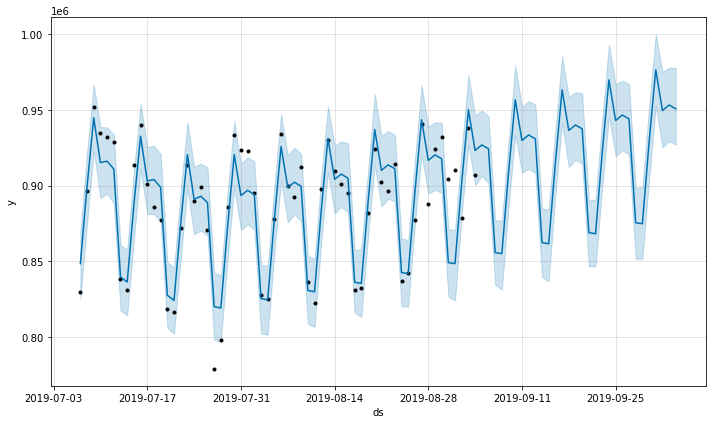

In [60]:
# Смотрим, что предсказалось
m.plot(forecast);

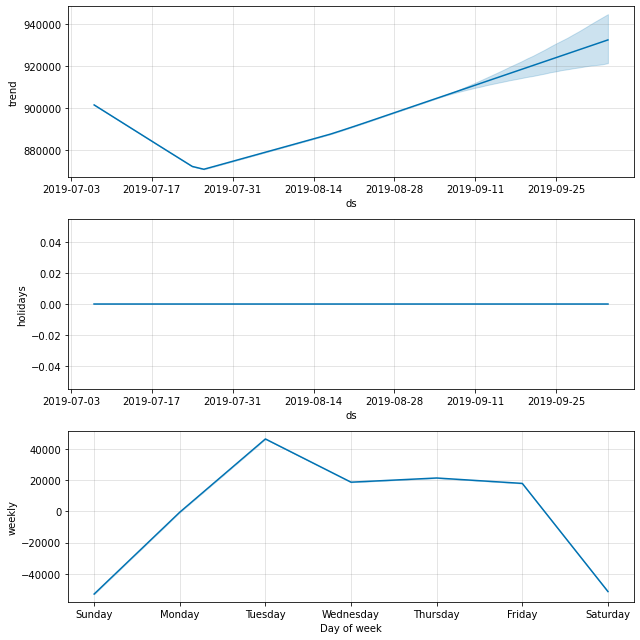

In [61]:
# Смотрим на сезонности
m.plot_components(forecast);

In [62]:
# Рисуем график с границами прогноза
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [63]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  2.183573818140955 %
MAE (средняя абсолютная ошибка) –  20006.003316472154


In [64]:
# Прогнозируем на полный период (указываем количество дней)
prediction_days = 180
final_train_df = df
f = Prophet(holidays=df_holidays, weekly_seasonality=True, yearly_seasonality=True)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


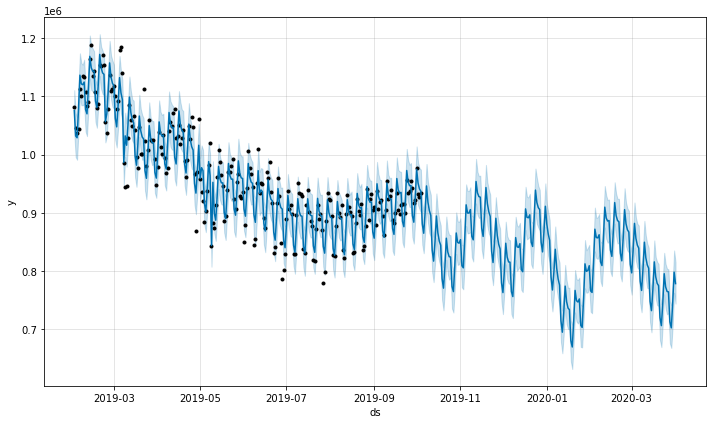

In [65]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast);

In [66]:
# Рисуем график с границами прогноза на полном периоде
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])

In [15]:
# Выгружаем прогноз в эксельку. Спрогнозированное значение лежит в столбце yhat
final_forecast.to_excel("./app_forecast.xlsx", sheet_name='Data', index=False, encoding="cp1251")

In [16]:
final_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,Православное Рождество,Православное Рождество_lower,Православное Рождество_upper,Праздник Весны и Труда,Праздник Весны и Труда_lower,Праздник Весны и Труда_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01,80.428061,44.957232,113.375045,80.428061,80.428061,-0.878640,-0.878640,-0.878640,5.090796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.549420
1,2016-01-02,80.444231,-14.487062,55.319012,80.444231,80.444231,-59.678480,-59.678480,-59.678480,5.090796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.765751
2,2016-01-03,80.460402,-16.320078,55.923873,80.460402,80.460402,-58.587722,-58.587722,-58.587722,5.090796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.872680
3,2016-01-04,80.476573,50.895332,121.849552,80.476573,80.476573,6.688870,6.688870,6.688870,5.090796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.165443
4,2016-01-05,80.492744,60.766107,128.404320,80.492744,80.492744,14.419617,14.419617,14.419617,5.090796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.912360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,2017-12-20,451.939994,423.612708,503.902681,434.833443,469.265382,12.077611,12.077611,12.077611,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,464.017605
720,2017-12-21,452.811850,422.488477,499.589866,435.589179,470.232953,9.358213,9.358213,9.358213,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,462.170063
721,2017-12-22,453.683706,409.468271,488.704410,436.354582,471.182098,-4.385765,-4.385765,-4.385765,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,449.297941
722,2017-12-23,454.555561,350.559663,429.576834,437.094799,472.130917,-63.559447,-63.559447,-63.559447,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,390.996115
